In [1]:
ASSET = "DOGEUSDT"
TARGET = "MA_7"
SAVE_DF = f"./-for_optimization-/{ASSET}_{TARGET}_df.csv"
SAVE_SCALER = f"./-for_optimization-/{ASSET}_{TARGET}_scaler.pkl"
SAVE_MODEL = f"./-for_optimization-/{ASSET}_{TARGET}_model.keras"
SAVE_PREDICTIONS = f"./-for_optimization-/{ASSET}_{TARGET}_predictions.csv"


import optuna
from keras.optimizers import Adam, RMSprop
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import importlib
# from __imports__ import *
import data, LSTM_returns
importlib.reload(data)


c:\Users\IC2594\AppData\Local\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<module 'data' from 'c:\\Users\\IC2594\\crypto\\folder-1\\data\\__init__.py'>

In [2]:
import numpy as np
import pandas as pd
import ta  # pip install ta

def compute_slope(series):
    y = series.values
    x = np.arange(len(y))
    if len(y) == 0:
        return np.nan
    return np.polyfit(x, y, 1)[0]

def add_technical_features(df, look_back=14):
    df = df.copy()  # avoid modifying original

    # Return: Daily log return
    df['Return'] = np.log(df['Close'] / df['Close'].shift(1))

    # Risk: Rolling std dev (volatility)
    df['Risk'] = df['Return'].rolling(window=look_back).std()

    # RSI
    df['RSI'] = ta.momentum.RSIIndicator(close=df['Close'], window=look_back).rsi()

    # ADX
    df['ADX'] = ta.trend.ADXIndicator(high=df['High'], low=df['Low'], close=df['Close'], window=look_back).adx()

    # Momentum
    df['MOM'] = df['Close'] - df['Close'].shift(look_back)

    # High-low spread
    df['HL'] = df['High'] - df['Low']

    # High-open & low-open
    df['HO'] = df['High'] - df['Open']
    df['LO'] = df['Low'] - df['Open']

    # Buy pressure ratio
    df['buy_pressure_ratio'] = df['Taker buy quote asset volume'] / df['Quote asset volume']

    # Trades per volume
    df['trades_per_volume'] = df['Number of trades'] / df['Quote asset volume']

    # Rolling slope
    df['slope'] = df['Close'].rolling(window=look_back).apply(compute_slope, raw=False)

    df['MA_7'] = df['Close'].rolling(window=7).mean()

    df['MA_14'] = df['Close'].rolling(window=14).mean()


    # Drop NaN from lookback window
    df = df.dropna()

    # Drop unnecessary columns
    cols_to_drop = [
        'Open', 'High', 'Low', 'Quote asset volume',
        'Number of trades', 'Taker buy base asset volume',
        'Taker buy quote asset volume', 'F&G'
    ]
    df = df.drop(columns=[col for col in cols_to_drop if col in df.columns])

    return df

df = data.load_asset(ASSET, sampling='1d')
df = data.add_fear_and_greed(df)
# Restrict data after 2022
df = add_technical_features(df)
df = df[df.index >= '2022-01-01']
df = df[df.index <= '2025-01-01']
split = len(df[df.index >= '2024-06-01']) / len(df)
df.head()

,Close,Volume,F&G category,Return,Risk,RSI,ADX,MOM,HL,HO,LO,buy_pressure_ratio,trades_per_volume,slope,MA_7,MA_14
Open time,,,,,,,,,,,,,,,,
2022-01-01,0.1732,2.975041e+08,Extreme Fear,0.016885,0.033048,44.190785,20.670453,0.0009,0.0040,0.0034,-0.0006,0.532811,0.001528,0.000004,0.176314,0.176886
2022-01-02,0.1745,3.129559e+08,Fear,0.007478,0.032705,45.171335,20.229684,0.0051,0.0058,0.0032,-0.0026,0.521954,0.001912,-0.000311,0.174129,0.177250
2022-01-03,0.1703,4.609854e+08,Fear,-0.024363,0.033223,42.569086,20.080075,0.0032,0.0071,0.0000,-0.0071,0.513585,0.001768,-0.000844,0.171614,0.177479
2022-01-04,0.1684,4.964392e+08,Extreme Fear,-0.011219,0.032855,41.406973,20.017871,-0.0023,0.0061,0.0023,-0.0038,0.520611,0.001510,-0.001327,0.170829,0.177314
2022-01-05,0.1590,1.084632e+09,Extreme Fear,-0.057438,0.035796,36.149096,21.302001,-0.0140,0.0238,0.0025,-0.0213,0.480378,0.001754,-0.001993,0.169543,0.176314


In [3]:
# Hyperparameters (from Optuna)
UNITS_L0 = 160
DROPOUT_L0 = 0.0
LEARNING_RATE = 0.000728
BATCH_SIZE = 32
MAX_EPOCHS = 50

def train_lstm(df, sequence_length=30, test_size=split, target='MA_7'):
    # Prepare data
    features = [
        'Close', 'Volume', 'F&G category', 'Return', 'Risk', 'RSI', 'ADX',
        'MOM', 'HL', 'HO', 'LO', 'buy_pressure_ratio', 'trades_per_volume', 
        'slope', 'MA_7', 'MA_14'
    ]
    num_feats = [f for f in features if f != 'F&G category']
    df_num = df[num_feats]
    df_cat = pd.get_dummies(df['F&G category'], prefix='F_G')
    df_all = pd.concat([df_num, df_cat], axis=1).dropna()
    target_idx = list(df_all.columns).index(target)
    # Move the target column to the last position
    columns = list(df_all.columns)
    columns.append(columns.pop(target_idx))
    df_all = df_all[columns]
    target_idx = len(columns) - 1

    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(df_all)

    # Build sequences
    X, y = zip(*[
        (data_scaled[i-sequence_length:i], data_scaled[i, target_idx])
        for i in range(sequence_length, len(data_scaled))
    ])
    X, y = np.array(X), np.array(y)

    # Train-test split
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, shuffle=False)

    # Build and compile model
    model = Sequential([
        Input(shape=(sequence_length, X.shape[2])),
        LSTM(UNITS_L0, dropout=DROPOUT_L0),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='mean_squared_error')

    # Train model
    es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                        epochs=MAX_EPOCHS, batch_size=BATCH_SIZE, callbacks=[es], verbose=1)

    return model, scaler, history, (X_val, y_val), df_all, data_scaled



In [4]:
def objective(trial):
    global UNITS_L0, DROPOUT_L0, LEARNING_RATE, BATCH_SIZE, MAX_EPOCHS

    # Suggest hyperparameters
    UNITS_L0 = trial.suggest_int("units_l0", 50, 200)
    DROPOUT_L0 = trial.suggest_float("dropout_l0", 0.0, 0.5)
    LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
    BATCH_SIZE = trial.suggest_categorical("batch_size", [16, 32, 64])
    MAX_EPOCHS = trial.suggest_int("max_epochs", 10, 100)
    sequence_length = trial.suggest_int("sequence_length", 10, 60)


    # Train the LSTM model
    model, scaler, history, (X_val, y_val), _, _ = train_lstm(
        df,
        sequence_length=sequence_length,
        test_size=split,
        target=TARGET
    )

    # Predict on validation set
    y_pred = model.predict(X_val).flatten()

    # Create a placeholder array with zeros, except for the last column (target)
    dummy = np.zeros((len(y_pred), X_val.shape[2]))
    dummy[:, -1] = y_pred

    # Inverse transform using the entire dummy array
    y_pred_inv = scaler.inverse_transform(dummy)[:, -1]

    # Inverse transform for the actual values
    dummy_y_val = np.zeros((len(y_val), X_val.shape[2]))
    dummy_y_val[:, -1] = y_val
    y_val_inv = scaler.inverse_transform(dummy_y_val)[:, -1]

    # Calculate MSE
    mse = mean_squared_error(y_val_inv, y_pred_inv)

    return mse

# Run Optuna optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=40)

[I 2025-05-09 19:33:40,581] A new study created in memory with name: no-name-e1be188b-0665-412b-9886-3e186e86f824


Epoch 1/84


C:\Users\IC2594\AppData\Local\Temp\ipykernel_15584\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0234 - val_loss: 0.0256
Epoch 2/84
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0014 - val_loss: 0.0180
Epoch 3/84
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0014 - val_loss: 0.0222
Epoch 4/84
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0016 - val_loss: 0.0232
Epoch 5/84
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0014 - val_loss: 0.0281
Epoch 6/84
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0015 - val_loss: 0.0353
Epoch 7/84
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0012 - val_loss: 0.0328
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


[I 2025-05-09 19:33:48,352] Trial 0 finished with value: 0.002575066744302979 and parameters: {'units_l0': 67, 'dropout_l0': 0.2595894402300863, 'learning_rate': 0.002657102356900732, 'batch_size': 16, 'max_epochs': 84, 'sequence_length': 45}. Best is trial 0 with value: 0.002575066744302979.


Epoch 1/32


C:\Users\IC2594\AppData\Local\Temp\ipykernel_15584\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0080 - val_loss: 0.0084
Epoch 2/32
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 7.9201e-04 - val_loss: 0.0103
Epoch 3/32
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 3.8983e-04 - val_loss: 0.0089
Epoch 4/32
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 6.2723e-04 - val_loss: 0.0128
Epoch 5/32
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 4.2193e-04 - val_loss: 0.0171
Epoch 6/32
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 4.9752e-04 - val_loss: 0.0175
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


[I 2025-05-09 19:33:57,402] Trial 1 finished with value: 0.0012052256245943251 and parameters: {'units_l0': 110, 'dropout_l0': 0.07065204217296744, 'learning_rate': 0.0009655599271818403, 'batch_size': 16, 'max_epochs': 32, 'sequence_length': 48}. Best is trial 1 with value: 0.0012052256245943251.


Epoch 1/46


C:\Users\IC2594\AppData\Local\Temp\ipykernel_15584\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0200 - val_loss: 0.0164
Epoch 2/46
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 8.5360e-04 - val_loss: 0.0149
Epoch 3/46
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 9.1085e-04 - val_loss: 0.0183
Epoch 4/46
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 8.3335e-04 - val_loss: 0.0181
Epoch 5/46
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 7.8570e-04 - val_loss: 0.0161
Epoch 6/46
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 8.2121e-04 - val_loss: 0.0171
Epoch 7/46
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 7.4027e-04 - val_loss: 0.0158
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step


[I 2025-05-09 19:34:07,247] Trial 2 finished with value: 0.0021246484021339527 and parameters: {'units_l0': 130, 'dropout_l0': 0.1531603477251416, 'learning_rate': 0.001816476042636775, 'batch_size': 16, 'max_epochs': 46, 'sequence_length': 28}. Best is trial 1 with value: 0.0012052256245943251.


Epoch 1/58


C:\Users\IC2594\AppData\Local\Temp\ipykernel_15584\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 0.0063 - val_loss: 0.0160
Epoch 2/58
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 8.2796e-04 - val_loss: 0.0084
Epoch 3/58
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 5.4069e-04 - val_loss: 0.0076
Epoch 4/58
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 3.4780e-04 - val_loss: 0.0087
Epoch 5/58
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 2.4965e-04 - val_loss: 0.0066
Epoch 6/58
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2.9038e-04 - val_loss: 0.0065
Epoch 7/58
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 2.2515e-04 - val_loss: 0.0058
Epoch 8/58
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 2.2342e-04 - val_loss: 0.0037
Epoch 9/58
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 2.7123e-04 - val_loss: 0.0054
Epoch 10/58
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2.5790e-04 - val_loss: 0.0045
Epoch 11/58
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 2.9727e-04 - val_loss: 0.0042
Epoch 12/58
54/54 ━━━━━━━━━━━━━━━━

[I 2025-05-09 19:34:25,880] Trial 3 finished with value: 0.0005250322089107675 and parameters: {'units_l0': 166, 'dropout_l0': 0.023987738241699585, 'learning_rate': 0.0001115986831878584, 'batch_size': 16, 'max_epochs': 58, 'sequence_length': 26}. Best is trial 3 with value: 0.0005250322089107675.


Epoch 1/36


C:\Users\IC2594\AppData\Local\Temp\ipykernel_15584\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - loss: 0.0273 - val_loss: 0.0187
Epoch 2/36
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0028 - val_loss: 0.0104
Epoch 3/36
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0016 - val_loss: 0.0095
Epoch 4/36
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0010 - val_loss: 0.0080
Epoch 5/36
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0011 - val_loss: 0.0088
Epoch 6/36
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 9.8021e-04 - val_loss: 0.0129
Epoch 7/36
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 8.2202e-04 - val_loss: 0.0143
Epoch 8/36
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0011 - val_loss: 0.0128
Epoch 9/36
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 9.3219e-04 - val_loss: 0.0156
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step


[I 2025-05-09 19:34:35,489] Trial 4 finished with value: 0.0011389929254190067 and parameters: {'units_l0': 197, 'dropout_l0': 0.18472992924394704, 'learning_rate': 0.0007558082172888887, 'batch_size': 64, 'max_epochs': 36, 'sequence_length': 22}. Best is trial 3 with value: 0.0005250322089107675.


Epoch 1/71


C:\Users\IC2594\AppData\Local\Temp\ipykernel_15584\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0289 - val_loss: 0.0733
Epoch 2/71
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0053 - val_loss: 0.0329
Epoch 3/71
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0023 - val_loss: 0.0173
Epoch 4/71
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0015 - val_loss: 0.0139
Epoch 5/71
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0010 - val_loss: 0.0070
Epoch 6/71
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0013 - val_loss: 0.0101
Epoch 7/71
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0011 - val_loss: 0.0100
Epoch 8/71
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0010 - val_loss: 0.0117
Epoch 9/71
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0011 - val_loss: 0.0164
Epoch 10/71
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0013 - val_loss: 0.0083
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step


[I 2025-05-09 19:34:44,961] Trial 5 finished with value: 0.0010046295142064313 and parameters: {'units_l0': 119, 'dropout_l0': 0.16540389319336624, 'learning_rate': 0.00013199764623625398, 'batch_size': 16, 'max_epochs': 71, 'sequence_length': 13}. Best is trial 3 with value: 0.0005250322089107675.


Epoch 1/84


C:\Users\IC2594\AppData\Local\Temp\ipykernel_15584\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 0.0119 - val_loss: 0.0329
Epoch 2/84
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0031 - val_loss: 0.0239
Epoch 3/84
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0011 - val_loss: 0.0108
Epoch 4/84
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 8.9313e-04 - val_loss: 0.0085
Epoch 5/84
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 7.0768e-04 - val_loss: 0.0075
Epoch 6/84
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 8.9071e-04 - val_loss: 0.0075
Epoch 7/84
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 9.3736e-04 - val_loss: 0.0096
Epoch 8/84
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 6.4415e-04 - val_loss: 0.0132
Epoch 9/84
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 6.4302e-04 - val_loss: 0.0084
Epoch 10/84
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 6.2325e-04 - val_loss: 0.0106
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step


[I 2025-05-09 19:34:54,663] Trial 6 finished with value: 0.0010695669525193575 and parameters: {'units_l0': 150, 'dropout_l0': 0.10640758854427323, 'learning_rate': 0.0007620472885105144, 'batch_size': 64, 'max_epochs': 84, 'sequence_length': 23}. Best is trial 3 with value: 0.0005250322089107675.


Epoch 1/45


C:\Users\IC2594\AppData\Local\Temp\ipykernel_15584\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0112 - val_loss: 0.0037
Epoch 2/45
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 2.8595e-04 - val_loss: 0.0048
Epoch 3/45
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 3.5096e-04 - val_loss: 0.0037
Epoch 4/45
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 2.8023e-04 - val_loss: 0.0058
Epoch 5/45
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 2.5010e-04 - val_loss: 0.0055
Epoch 6/45
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.2158e-04 - val_loss: 0.0029
Epoch 7/45
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 2.2516e-04 - val_loss: 0.0040
Epoch 8/45
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.5133e-04 - val_loss: 0.0030
Epoch 9/45
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 3.5704e-04 - val_loss: 0.0029
Epoch 10/45
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 2.3954e-04 - val_loss: 0.0052
Epoch 11/45
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 2.1357e-04 - val_loss: 0.0034
Epoch 12/45
54/54 ━━━━━━━━━━━━━━━━

[I 2025-05-09 19:35:10,914] Trial 7 finished with value: 0.0004118468908168232 and parameters: {'units_l0': 128, 'dropout_l0': 0.027397204591356916, 'learning_rate': 0.0014123342635539759, 'batch_size': 16, 'max_epochs': 45, 'sequence_length': 38}. Best is trial 7 with value: 0.0004118468908168232.


Epoch 1/35


C:\Users\IC2594\AppData\Local\Temp\ipykernel_15584\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0255 - val_loss: 0.1046
Epoch 2/35
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0077 - val_loss: 0.0810
Epoch 3/35
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0067 - val_loss: 0.0682
Epoch 4/35
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0051 - val_loss: 0.0535
Epoch 5/35
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0039 - val_loss: 0.0446
Epoch 6/35
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0028 - val_loss: 0.0370
Epoch 7/35
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0023 - val_loss: 0.0307
Epoch 8/35
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0023 - val_loss: 0.0271
Epoch 9/35
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0018 - val_loss: 0.0230
Epoch 10/35
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0017 - val_loss: 0.0187
Epoch 11/35
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0017 - val_loss: 0.0170
Epoch 12/35
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0015 - val_l

[I 2025-05-09 19:35:44,338] Trial 8 finished with value: 0.0013485906150850235 and parameters: {'units_l0': 165, 'dropout_l0': 0.15439514139483074, 'learning_rate': 1.2341646595185349e-05, 'batch_size': 16, 'max_epochs': 35, 'sequence_length': 13}. Best is trial 7 with value: 0.0004118468908168232.


Epoch 1/24


C:\Users\IC2594\AppData\Local\Temp\ipykernel_15584\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 0.0265 - val_loss: 0.0426
Epoch 2/24
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0037 - val_loss: 0.0316
Epoch 3/24
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0028 - val_loss: 0.0274
Epoch 4/24
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0033 - val_loss: 0.0289
Epoch 5/24
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0030 - val_loss: 0.0285
Epoch 6/24
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0029 - val_loss: 0.0291
Epoch 7/24
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0028 - val_loss: 0.0337
Epoch 8/24
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0023 - val_loss: 0.0315
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step


[I 2025-05-09 19:35:54,181] Trial 9 finished with value: 0.003921363603812325 and parameters: {'units_l0': 61, 'dropout_l0': 0.48122618804721595, 'learning_rate': 0.001043305199693404, 'batch_size': 32, 'max_epochs': 24, 'sequence_length': 25}. Best is trial 7 with value: 0.0004118468908168232.


Epoch 1/13


C:\Users\IC2594\AppData\Local\Temp\ipykernel_15584\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - loss: 0.1441 - val_loss: 0.0490
Epoch 2/13
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0039 - val_loss: 0.0319
Epoch 3/13
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0019 - val_loss: 0.0266
Epoch 4/13
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0019 - val_loss: 0.0278
Epoch 5/13
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0014 - val_loss: 0.0308
Epoch 6/13
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0019 - val_loss: 0.0303
Epoch 7/13
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0017 - val_loss: 0.0359
Epoch 8/13
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0014 - val_loss: 0.0340
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step


[I 2025-05-09 19:36:06,587] Trial 10 finished with value: 0.003800572430573155 and parameters: {'units_l0': 87, 'dropout_l0': 0.32971245940579175, 'learning_rate': 0.00667069322686938, 'batch_size': 32, 'max_epochs': 13, 'sequence_length': 59}. Best is trial 7 with value: 0.0004118468908168232.


Epoch 1/62


C:\Users\IC2594\AppData\Local\Temp\ipykernel_15584\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - loss: 0.0127 - val_loss: 0.0448
Epoch 2/62
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0015 - val_loss: 0.0237
Epoch 3/62
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 7.0541e-04 - val_loss: 0.0180
Epoch 4/62
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 4.3720e-04 - val_loss: 0.0140
Epoch 5/62
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 3.9494e-04 - val_loss: 0.0138
Epoch 6/62
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 2.4132e-04 - val_loss: 0.0112
Epoch 7/62
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 2.4265e-04 - val_loss: 0.0102
Epoch 8/62
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 2.0913e-04 - val_loss: 0.0109
Epoch 9/62
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 2.5255e-04 - val_loss: 0.0105
Epoch 10/62
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 1.5995e-04 - val_loss: 0.0095
Epoch 11/62
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 2.1101e-04 - val_loss: 0.0089
Epoch 12/62
54/54 ━━━━━━━━━━━━━━━━━━━

[I 2025-05-09 19:36:38,294] Trial 11 finished with value: 0.0010171841846332386 and parameters: {'units_l0': 172, 'dropout_l0': 0.017067708721268636, 'learning_rate': 0.0001177541038545812, 'batch_size': 16, 'max_epochs': 62, 'sequence_length': 37}. Best is trial 7 with value: 0.0004118468908168232.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_15584\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/58
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 0.0371 - val_loss: 0.1139
Epoch 2/58
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0081 - val_loss: 0.0833
Epoch 3/58
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0051 - val_loss: 0.0536
Epoch 4/58
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0033 - val_loss: 0.0385
Epoch 5/58
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0024 - val_loss: 0.0279
Epoch 6/58
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0019 - val_loss: 0.0236
Epoch 7/58
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0015 - val_loss: 0.0217
Epoch 8/58
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0011 - val_loss: 0.0183
Epoch 9/58
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0012 - val_loss: 0.0168
Epoch 10/58
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 9.0450e-04 - val_loss: 0.0149
Epoch 11/58
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 7.7355e-04 - val_loss: 0.0151
Epoch 12/58
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - l

[I 2025-05-09 19:37:18,263] Trial 12 finished with value: 0.001391999368182023 and parameters: {'units_l0': 145, 'dropout_l0': 0.017984575602858856, 'learning_rate': 2.9738699999111924e-05, 'batch_size': 16, 'max_epochs': 58, 'sequence_length': 36}. Best is trial 7 with value: 0.0004118468908168232.


Epoch 1/100


C:\Users\IC2594\AppData\Local\Temp\ipykernel_15584\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - loss: 0.0193 - val_loss: 0.0559
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0035 - val_loss: 0.0375
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0011 - val_loss: 0.0256
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 5.0602e-04 - val_loss: 0.0206
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 3.5157e-04 - val_loss: 0.0199
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 3.5008e-04 - val_loss: 0.0172
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 3.2156e-04 - val_loss: 0.0189
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 2.7084e-04 - val_loss: 0.0148
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 2.3538e-04 - val_loss: 0.0123
Epoch 10/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 2.1980e-04 - val_loss: 0.0149
Epoch 11/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 1.8364e-04 - val_loss: 0.0136
Epoch 12/100
27/27 ━━━━━━━━━━━━━

[I 2025-05-09 19:38:03,239] Trial 13 finished with value: 0.0009577509115035549 and parameters: {'units_l0': 191, 'dropout_l0': 0.009832071045949537, 'learning_rate': 0.00020377546658249113, 'batch_size': 32, 'max_epochs': 100, 'sequence_length': 43}. Best is trial 7 with value: 0.0004118468908168232.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_15584\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/49
54/54 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - loss: 0.0988 - val_loss: 0.1141
Epoch 2/49
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0111 - val_loss: 0.0896
Epoch 3/49
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0075 - val_loss: 0.0632
Epoch 4/49
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0054 - val_loss: 0.0497
Epoch 5/49
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0040 - val_loss: 0.0371
Epoch 6/49
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0035 - val_loss: 0.0295
Epoch 7/49
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0031 - val_loss: 0.0255
Epoch 8/49
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0023 - val_loss: 0.0215
Epoch 9/49
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0024 - val_loss: 0.0202
Epoch 10/49
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0024 - val_loss: 0.0173
Epoch 11/49
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0022 - val_loss: 0.0177
Epoch 12/49
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0

[I 2025-05-09 19:38:31,718] Trial 14 finished with value: 0.001986338024018921 and parameters: {'units_l0': 109, 'dropout_l0': 0.3515993399079029, 'learning_rate': 6.10625715433747e-05, 'batch_size': 16, 'max_epochs': 49, 'sequence_length': 31}. Best is trial 7 with value: 0.0004118468908168232.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_15584\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/75
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 172ms/step - loss: 0.0287 - val_loss: 0.0901
Epoch 2/75
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 0.0051 - val_loss: 0.0391
Epoch 3/75
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0024 - val_loss: 0.0192
Epoch 4/75
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0014 - val_loss: 0.0175
Epoch 5/75
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 8.0136e-04 - val_loss: 0.0149
Epoch 6/75
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 7.0319e-04 - val_loss: 0.0125
Epoch 7/75
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 5.0865e-04 - val_loss: 0.0109
Epoch 8/75
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 5.0102e-04 - val_loss: 0.0111
Epoch 9/75
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 5.3827e-04 - val_loss: 0.0106
Epoch 10/75
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 6.1410e-04 - val_loss: 0.0124
Epoch 11/75
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 5.5968e-04 - val_loss: 0.0114
Epoch 12/75
14/14 ━━━━━━━━━━━━━━━━

[I 2025-05-09 19:38:54,005] Trial 15 finished with value: 0.0015162942776857742 and parameters: {'units_l0': 170, 'dropout_l0': 0.0873819265029595, 'learning_rate': 0.0003736538491583666, 'batch_size': 64, 'max_epochs': 75, 'sequence_length': 59}. Best is trial 7 with value: 0.0004118468908168232.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_15584\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/47
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.1538 - val_loss: 0.0177
Epoch 2/47
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0021 - val_loss: 0.0245
Epoch 3/47
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0015 - val_loss: 0.0182
Epoch 4/47
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0015 - val_loss: 0.0303
Epoch 5/47
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0013 - val_loss: 0.0288
Epoch 6/47
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0013 - val_loss: 0.0335
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step


[I 2025-05-09 19:39:03,628] Trial 16 finished with value: 0.002526182211089675 and parameters: {'units_l0': 140, 'dropout_l0': 0.2545997072188299, 'learning_rate': 0.0090082830060394, 'batch_size': 16, 'max_epochs': 47, 'sequence_length': 18}. Best is trial 7 with value: 0.0004118468908168232.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_15584\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/67
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0201 - val_loss: 0.0129
Epoch 2/67
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0013 - val_loss: 0.0088
Epoch 3/67
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 6.8353e-04 - val_loss: 0.0082
Epoch 4/67
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 5.1807e-04 - val_loss: 0.0100
Epoch 5/67
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 4.3936e-04 - val_loss: 0.0114
Epoch 6/67
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 4.4457e-04 - val_loss: 0.0095
Epoch 7/67
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 4.0690e-04 - val_loss: 0.0108
Epoch 8/67
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 4.3171e-04 - val_loss: 0.0108
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 222ms/step


[I 2025-05-09 19:39:17,542] Trial 17 finished with value: 0.001170456658628442 and parameters: {'units_l0': 94, 'dropout_l0': 0.06819502920386174, 'learning_rate': 0.0004006469414499484, 'batch_size': 16, 'max_epochs': 67, 'sequence_length': 40}. Best is trial 7 with value: 0.0004118468908168232.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_15584\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/54
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - loss: 0.1304 - val_loss: 0.0675
Epoch 2/54
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0037 - val_loss: 0.0272
Epoch 3/54
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0024 - val_loss: 0.0274
Epoch 4/54
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0021 - val_loss: 0.0276
Epoch 5/54
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0023 - val_loss: 0.0304
Epoch 6/54
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0020 - val_loss: 0.0354
Epoch 7/54
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0019 - val_loss: 0.0307
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step


[I 2025-05-09 19:39:32,893] Trial 18 finished with value: 0.0038922964838843228 and parameters: {'units_l0': 156, 'dropout_l0': 0.4213700234055366, 'learning_rate': 0.003774947867575284, 'batch_size': 32, 'max_epochs': 54, 'sequence_length': 50}. Best is trial 7 with value: 0.0004118468908168232.


Epoch 1/22


C:\Users\IC2594\AppData\Local\Temp\ipykernel_15584\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - loss: 0.0389 - val_loss: 0.1582
Epoch 2/22
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0141 - val_loss: 0.1079
Epoch 3/22
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0098 - val_loss: 0.0958
Epoch 4/22
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0080 - val_loss: 0.0900
Epoch 5/22
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0064 - val_loss: 0.0803
Epoch 6/22
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0052 - val_loss: 0.0695
Epoch 7/22
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0046 - val_loss: 0.0587
Epoch 8/22
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0043 - val_loss: 0.0518
Epoch 9/22
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0032 - val_loss: 0.0446
Epoch 10/22
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0033 - val_loss: 0.0376
Epoch 11/22
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0027 - val_loss: 0.0349
Epoch 12/22
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0022 - val_

[I 2025-05-09 19:39:55,890] Trial 19 finished with value: 0.0026459804069587462 and parameters: {'units_l0': 185, 'dropout_l0': 0.2110888080234471, 'learning_rate': 3.1914830013699366e-05, 'batch_size': 64, 'max_epochs': 22, 'sequence_length': 30}. Best is trial 7 with value: 0.0004118468908168232.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_15584\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/42
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - loss: 0.0134 - val_loss: 0.0552
Epoch 2/42
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0031 - val_loss: 0.0171
Epoch 3/42
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0012 - val_loss: 0.0090
Epoch 4/42
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0011 - val_loss: 0.0093
Epoch 5/42
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 9.9807e-04 - val_loss: 0.0094
Epoch 6/42
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 9.1934e-04 - val_loss: 0.0120
Epoch 7/42
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7.5683e-04 - val_loss: 0.0086
Epoch 8/42
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7.1357e-04 - val_loss: 0.0114
Epoch 9/42
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7.5006e-04 - val_loss: 0.0096
Epoch 10/42
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7.2506e-04 - val_loss: 0.0114
Epoch 11/42
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 6.7541e-04 - val_loss: 0.0117
Epoch 12/42
54/54 ━━━━━━━━━━━━━━━━━

[I 2025-05-09 19:40:15,345] Trial 20 finished with value: 0.0012272243619958268 and parameters: {'units_l0': 134, 'dropout_l0': 0.11830385915073102, 'learning_rate': 6.891002060612854e-05, 'batch_size': 16, 'max_epochs': 42, 'sequence_length': 33}. Best is trial 7 with value: 0.0004118468908168232.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_15584\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/93
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - loss: 0.0116 - val_loss: 0.0195
Epoch 2/93
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0012 - val_loss: 0.0099
Epoch 3/93
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 2.9284e-04 - val_loss: 0.0091
Epoch 4/93
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 2.4266e-04 - val_loss: 0.0073
Epoch 5/93
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 1.4830e-04 - val_loss: 0.0077
Epoch 6/93
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 1.1234e-04 - val_loss: 0.0069
Epoch 7/93
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 1.1691e-04 - val_loss: 0.0059
Epoch 8/93
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 9.0594e-05 - val_loss: 0.0053
Epoch 9/93
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 9.7101e-05 - val_loss: 0.0056
Epoch 10/93
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 6.9209e-05 - val_loss: 0.0062
Epoch 11/93
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 1.1445e-04 - val_loss: 0.0062
Epoch 12/93
27/27 ━━━━━━━━━

[I 2025-05-09 19:41:04,920] Trial 21 finished with value: 0.00028666609679632143 and parameters: {'units_l0': 197, 'dropout_l0': 0.0014397628809743046, 'learning_rate': 0.00019995386436480632, 'batch_size': 32, 'max_epochs': 93, 'sequence_length': 41}. Best is trial 21 with value: 0.00028666609679632143.


Epoch 1/98


C:\Users\IC2594\AppData\Local\Temp\ipykernel_15584\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - loss: 0.0037 - val_loss: 0.0195
Epoch 2/98
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 6.9356e-04 - val_loss: 0.0067
Epoch 3/98
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 2.7717e-04 - val_loss: 0.0068
Epoch 4/98
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 2.0265e-04 - val_loss: 0.0078
Epoch 5/98
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 1.1184e-04 - val_loss: 0.0068
Epoch 6/98
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 1.1710e-04 - val_loss: 0.0060
Epoch 7/98
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 1.1676e-04 - val_loss: 0.0062
Epoch 8/98
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 1.0988e-04 - val_loss: 0.0071
Epoch 9/98
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 9.7073e-05 - val_loss: 0.0073
Epoch 10/98
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 1.3764e-04 - val_loss: 0.0058
Epoch 11/98
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 7.0871e-05 - val_loss: 0.0062
Epoch 12/98
27/27 ━━━━━━━━━━━━━━━━

[I 2025-05-09 19:41:40,965] Trial 22 finished with value: 0.0005898635323910623 and parameters: {'units_l0': 181, 'dropout_l0': 0.004999520154230663, 'learning_rate': 0.00020384289412957217, 'batch_size': 32, 'max_epochs': 98, 'sequence_length': 51}. Best is trial 21 with value: 0.00028666609679632143.


Epoch 1/92


C:\Users\IC2594\AppData\Local\Temp\ipykernel_15584\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - loss: 0.0138 - val_loss: 0.0131
Epoch 2/92
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0014 - val_loss: 0.0107
Epoch 3/92
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 4.9130e-04 - val_loss: 0.0066
Epoch 4/92
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 4.7050e-04 - val_loss: 0.0143
Epoch 5/92
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 4.9229e-04 - val_loss: 0.0097
Epoch 6/92
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 4.4628e-04 - val_loss: 0.0097
Epoch 7/92
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 3.8611e-04 - val_loss: 0.0089
Epoch 8/92
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 4.0004e-04 - val_loss: 0.0080
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step


[I 2025-05-09 19:41:55,757] Trial 23 finished with value: 0.0009377261600923209 and parameters: {'units_l0': 200, 'dropout_l0': 0.0557485006565675, 'learning_rate': 0.0004443588313868848, 'batch_size': 32, 'max_epochs': 92, 'sequence_length': 41}. Best is trial 21 with value: 0.00028666609679632143.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_15584\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 0.0281 - val_loss: 0.0715
Epoch 2/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0041 - val_loss: 0.0288
Epoch 3/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0021 - val_loss: 0.0158
Epoch 4/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0015 - val_loss: 0.0114
Epoch 5/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 8.6310e-04 - val_loss: 0.0099
Epoch 6/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 5.7499e-04 - val_loss: 0.0090
Epoch 7/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 4.8642e-04 - val_loss: 0.0082
Epoch 8/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 4.4198e-04 - val_loss: 0.0082
Epoch 9/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 5.1928e-04 - val_loss: 0.0076
Epoch 10/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 4.7449e-04 - val_loss: 0.0089
Epoch 11/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 4.4522e-04 - val_loss: 0.0083
Epoch 12/80
27/27 ━━━━━━━━━━━━━━━━━

[I 2025-05-09 19:42:20,196] Trial 24 finished with value: 0.0010617756322735782 and parameters: {'units_l0': 179, 'dropout_l0': 0.04828653920545282, 'learning_rate': 8.4697195049716e-05, 'batch_size': 32, 'max_epochs': 80, 'sequence_length': 37}. Best is trial 21 with value: 0.00028666609679632143.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_15584\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/64
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - loss: 0.0173 - val_loss: 0.0298
Epoch 2/64
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0027 - val_loss: 0.0098
Epoch 3/64
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 9.7498e-04 - val_loss: 0.0055
Epoch 4/64
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0012 - val_loss: 0.0074
Epoch 5/64
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 8.7453e-04 - val_loss: 0.0072
Epoch 6/64
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0011 - val_loss: 0.0087
Epoch 7/64
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 8.7817e-04 - val_loss: 0.0073
Epoch 8/64
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 8.2031e-04 - val_loss: 0.0101
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


[I 2025-05-09 19:42:30,864] Trial 25 finished with value: 0.0007812402803257672 and parameters: {'units_l0': 161, 'dropout_l0': 0.11827261464402644, 'learning_rate': 0.00024147177965055545, 'batch_size': 32, 'max_epochs': 64, 'sequence_length': 19}. Best is trial 21 with value: 0.00028666609679632143.


Epoch 1/56


C:\Users\IC2594\AppData\Local\Temp\ipykernel_15584\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - loss: 0.0129 - val_loss: 0.0853
Epoch 2/56
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0060 - val_loss: 0.0530
Epoch 3/56
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0031 - val_loss: 0.0352
Epoch 4/56
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0023 - val_loss: 0.0236
Epoch 5/56
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0020 - val_loss: 0.0220
Epoch 6/56
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0016 - val_loss: 0.0182
Epoch 7/56
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0012 - val_loss: 0.0155
Epoch 8/56
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0011 - val_loss: 0.0147
Epoch 9/56
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 8.3143e-04 - val_loss: 0.0128
Epoch 10/56
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 7.2733e-04 - val_loss: 0.0125
Epoch 11/56
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 7.0624e-04 - val_loss: 0.0122
Epoch 12/56
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 6.

[I 2025-05-09 19:43:03,912] Trial 26 finished with value: 0.0010009982724760419 and parameters: {'units_l0': 89, 'dropout_l0': 0.04286346906705948, 'learning_rate': 4.486661391724163e-05, 'batch_size': 16, 'max_epochs': 56, 'sequence_length': 27}. Best is trial 21 with value: 0.00028666609679632143.


Epoch 1/90


C:\Users\IC2594\AppData\Local\Temp\ipykernel_15584\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.0177 - val_loss: 0.0120
Epoch 2/90
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0018 - val_loss: 0.0194
Epoch 3/90
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0016 - val_loss: 0.0180
Epoch 4/90
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0018 - val_loss: 0.0310
Epoch 5/90
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0016 - val_loss: 0.0336
Epoch 6/90
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0015 - val_loss: 0.0402
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step


[I 2025-05-09 19:43:17,038] Trial 27 finished with value: 0.001711841068395985 and parameters: {'units_l0': 154, 'dropout_l0': 0.30894348699901064, 'learning_rate': 0.0014886530736054678, 'batch_size': 16, 'max_epochs': 90, 'sequence_length': 53}. Best is trial 21 with value: 0.00028666609679632143.


Epoch 1/27


C:\Users\IC2594\AppData\Local\Temp\ipykernel_15584\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 92ms/step - loss: 0.0158 - val_loss: 0.1596
Epoch 2/27
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0155 - val_loss: 0.1512
Epoch 3/27
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0138 - val_loss: 0.1453
Epoch 4/27
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0124 - val_loss: 0.1396
Epoch 5/27
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0117 - val_loss: 0.1332
Epoch 6/27
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0110 - val_loss: 0.1256
Epoch 7/27
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0105 - val_loss: 0.1212
Epoch 8/27
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0088 - val_loss: 0.1168
Epoch 9/27
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0082 - val_loss: 0.1115
Epoch 10/27
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0077 - val_loss: 0.1065
Epoch 11/27
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0069 - val_loss: 0.1006
Epoch 12/27
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0072 - val_l

[I 2025-05-09 19:43:43,555] Trial 28 finished with value: 0.007102902083963817 and parameters: {'units_l0': 118, 'dropout_l0': 0.20938161133829042, 'learning_rate': 1.0627097203129487e-05, 'batch_size': 64, 'max_epochs': 27, 'sequence_length': 46}. Best is trial 21 with value: 0.00028666609679632143.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_15584\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/75
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - loss: 0.0693 - val_loss: 0.0255
Epoch 2/75
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0017 - val_loss: 0.0087
Epoch 3/75
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 6.9811e-04 - val_loss: 0.0098
Epoch 4/75
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 7.3791e-04 - val_loss: 0.0124
Epoch 5/75
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 6.1403e-04 - val_loss: 0.0103
Epoch 6/75
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 7.4690e-04 - val_loss: 0.0143
Epoch 7/75
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 5.7790e-04 - val_loss: 0.0095
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step


[I 2025-05-09 19:43:57,493] Trial 29 finished with value: 0.0012381518477748547 and parameters: {'units_l0': 187, 'dropout_l0': 0.09990062096287643, 'learning_rate': 0.0029132058198230214, 'batch_size': 32, 'max_epochs': 75, 'sequence_length': 33}. Best is trial 21 with value: 0.00028666609679632143.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_15584\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/44
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0134 - val_loss: 0.0108
Epoch 2/44
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 6.6546e-04 - val_loss: 0.0038
Epoch 3/44
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 2.5673e-04 - val_loss: 0.0032
Epoch 4/44
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.7831e-04 - val_loss: 0.0026
Epoch 5/44
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.2081e-04 - val_loss: 0.0031
Epoch 6/44
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.1743e-04 - val_loss: 0.0022
Epoch 7/44
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 7.5782e-05 - val_loss: 0.0026
Epoch 8/44
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 8.0383e-05 - val_loss: 0.0018
Epoch 9/44
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 4.4661e-05 - val_loss: 0.0018
Epoch 10/44
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 4.5902e-05 - val_loss: 9.3423e-04
Epoch 11/44
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 6.1589e-05 - val_loss: 0.0011
Epoch 12/44
54/54 ━

[I 2025-05-09 19:44:23,518] Trial 30 finished with value: 8.706865629719496e-05 and parameters: {'units_l0': 73, 'dropout_l0': 0.0005935961676833794, 'learning_rate': 0.0005872527347598729, 'batch_size': 16, 'max_epochs': 44, 'sequence_length': 39}. Best is trial 30 with value: 8.706865629719496e-05.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_15584\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/41
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0234 - val_loss: 0.0268
Epoch 2/41
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0017 - val_loss: 0.0190
Epoch 3/41
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 7.0427e-04 - val_loss: 0.0131
Epoch 4/41
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 4.7025e-04 - val_loss: 0.0099
Epoch 5/41
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 3.3718e-04 - val_loss: 0.0113
Epoch 6/41
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2.9169e-04 - val_loss: 0.0140
Epoch 7/41
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 3.1567e-04 - val_loss: 0.0102
Epoch 8/41
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 3.9295e-04 - val_loss: 0.0106
Epoch 9/41
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2.7578e-04 - val_loss: 0.0099
Epoch 10/41
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 3.3270e-04 - val_loss: 0.0109
Epoch 11/41
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2.3131e-04 - val_loss: 0.0120
Epoch 12/41
54/54 ━━━━━━━━━

[I 2025-05-09 19:44:41,613] Trial 31 finished with value: 0.0014083502053100978 and parameters: {'units_l0': 77, 'dropout_l0': 0.04311135422482239, 'learning_rate': 0.0005923154429495792, 'batch_size': 16, 'max_epochs': 41, 'sequence_length': 39}. Best is trial 30 with value: 8.706865629719496e-05.


Epoch 1/52


C:\Users\IC2594\AppData\Local\Temp\ipykernel_15584\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.0073 - val_loss: 0.0355
Epoch 2/52
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0014 - val_loss: 0.0177
Epoch 3/52
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 4.7857e-04 - val_loss: 0.0131
Epoch 4/52
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2.1642e-04 - val_loss: 0.0127
Epoch 5/52
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.7365e-04 - val_loss: 0.0106
Epoch 6/52
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.4643e-04 - val_loss: 0.0108
Epoch 7/52
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.0553e-04 - val_loss: 0.0091
Epoch 8/52
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 9.6821e-05 - val_loss: 0.0098
Epoch 9/52
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 9.9621e-05 - val_loss: 0.0092
Epoch 10/52
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 8.2536e-05 - val_loss: 0.0084
Epoch 11/52
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.2260e-04 - val_loss: 0.0094
Epoch 12/52
53/53 ━━━━━━━━━━━━━━━━━━━━

[I 2025-05-09 19:45:14,845] Trial 32 finished with value: 0.0007601487903528054 and parameters: {'units_l0': 102, 'dropout_l0': 0.005178793662367537, 'learning_rate': 0.00012365069293997062, 'batch_size': 16, 'max_epochs': 52, 'sequence_length': 45}. Best is trial 30 with value: 8.706865629719496e-05.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_15584\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/41
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0071 - val_loss: 0.0136
Epoch 2/41
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 8.3846e-04 - val_loss: 0.0111
Epoch 3/41
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 4.4028e-04 - val_loss: 0.0093
Epoch 4/41
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 4.5620e-04 - val_loss: 0.0066
Epoch 5/41
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 6.5181e-04 - val_loss: 0.0143
Epoch 6/41
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 4.0712e-04 - val_loss: 0.0105
Epoch 7/41
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 4.2540e-04 - val_loss: 0.0119
Epoch 8/41
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 6.0963e-04 - val_loss: 0.0124
Epoch 9/41
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 4.9960e-04 - val_loss: 0.0138
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


[I 2025-05-09 19:45:25,525] Trial 33 finished with value: 0.000938319896882646 and parameters: {'units_l0': 57, 'dropout_l0': 0.0774915600951292, 'learning_rate': 0.0015574918463522195, 'batch_size': 16, 'max_epochs': 41, 'sequence_length': 43}. Best is trial 30 with value: 8.706865629719496e-05.


Epoch 1/29


C:\Users\IC2594\AppData\Local\Temp\ipykernel_15584\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0140 - val_loss: 0.0490
Epoch 2/29
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0027 - val_loss: 0.0219
Epoch 3/29
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.7326e-04 - val_loss: 0.0234
Epoch 4/29
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 7.4946e-04 - val_loss: 0.0180
Epoch 5/29
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.5730e-04 - val_loss: 0.0225
Epoch 6/29
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.9863e-04 - val_loss: 0.0195
Epoch 7/29
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.0000e-04 - val_loss: 0.0209
Epoch 8/29
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.1318e-04 - val_loss: 0.0171
Epoch 9/29
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.6935e-04 - val_loss: 0.0199
Epoch 10/29
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.8248e-04 - val_loss: 0.0154
Epoch 11/29
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.1560e-04 - val_loss: 0.0170
Epoch 12/29
54/54 ━━━━━━━━━━━━━━━━━━━━

[I 2025-05-09 19:45:38,229] Trial 34 finished with value: 0.002204116744301919 and parameters: {'units_l0': 50, 'dropout_l0': 0.037224846038067846, 'learning_rate': 0.0002659493977410868, 'batch_size': 16, 'max_epochs': 29, 'sequence_length': 34}. Best is trial 30 with value: 8.706865629719496e-05.


Epoch 1/36


C:\Users\IC2594\AppData\Local\Temp\ipykernel_15584\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0121 - val_loss: 0.0100
Epoch 2/36
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 9.9073e-04 - val_loss: 0.0117
Epoch 3/36
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 7.2213e-04 - val_loss: 0.0128
Epoch 4/36
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 9.4140e-04 - val_loss: 0.0204
Epoch 5/36
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 7.7858e-04 - val_loss: 0.0186
Epoch 6/36
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 8.4202e-04 - val_loss: 0.0222
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


[I 2025-05-09 19:45:45,033] Trial 35 finished with value: 0.0014339427535303663 and parameters: {'units_l0': 73, 'dropout_l0': 0.13245411761134893, 'learning_rate': 0.0021846702341392936, 'batch_size': 16, 'max_epochs': 36, 'sequence_length': 29}. Best is trial 30 with value: 8.706865629719496e-05.


Epoch 1/16


C:\Users\IC2594\AppData\Local\Temp\ipykernel_15584\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0091 - val_loss: 0.0069
Epoch 2/16
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7.9141e-04 - val_loss: 0.0088
Epoch 3/16
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 4.3885e-04 - val_loss: 0.0066
Epoch 4/16
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 6.1582e-04 - val_loss: 0.0091
Epoch 5/16
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 5.8425e-04 - val_loss: 0.0116
Epoch 6/16
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 5.2179e-04 - val_loss: 0.0095
Epoch 7/16
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 3.7188e-04 - val_loss: 0.0130
Epoch 8/16
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 4.5384e-04 - val_loss: 0.0113
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


[I 2025-05-09 19:45:54,121] Trial 36 finished with value: 0.0009471635329903142 and parameters: {'units_l0': 125, 'dropout_l0': 0.07205189186246043, 'learning_rate': 0.0011366136316124994, 'batch_size': 16, 'max_epochs': 16, 'sequence_length': 39}. Best is trial 30 with value: 8.706865629719496e-05.


Epoch 1/44


C:\Users\IC2594\AppData\Local\Temp\ipykernel_15584\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0079 - val_loss: 0.0026
Epoch 2/44
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.0579e-04 - val_loss: 0.0017
Epoch 3/44
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.3892e-04 - val_loss: 0.0024
Epoch 4/44
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.0848e-04 - val_loss: 0.0012
Epoch 5/44
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.0862e-05 - val_loss: 0.0014
Epoch 6/44
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.0477e-05 - val_loss: 0.0012
Epoch 7/44
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.0411e-05 - val_loss: 0.0015
Epoch 8/44
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.6034e-05 - val_loss: 7.1415e-04
Epoch 9/44
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.3355e-05 - val_loss: 3.0608e-04
Epoch 10/44
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.3611e-04 - val_loss: 0.0010
Epoch 11/44
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.2633e-05 - val_loss: 6.2953e-04
Epoch 12/44
55/55 ━━━━━━━━━━━

[I 2025-05-09 19:46:04,528] Trial 37 finished with value: 4.374074345022805e-05 and parameters: {'units_l0': 135, 'dropout_l0': 0.00039499607016824523, 'learning_rate': 0.000571067626108476, 'batch_size': 16, 'max_epochs': 44, 'sequence_length': 20}. Best is trial 37 with value: 4.374074345022805e-05.


Epoch 1/43


C:\Users\IC2594\AppData\Local\Temp\ipykernel_15584\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0046 - val_loss: 0.0035
Epoch 2/43
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.4722e-04 - val_loss: 0.0040
Epoch 3/43
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.0708e-04 - val_loss: 0.0035
Epoch 4/43
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.0419e-04 - val_loss: 0.0043
Epoch 5/43
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 8.1222e-05 - val_loss: 0.0038
Epoch 6/43
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 6.7599e-05 - val_loss: 0.0022
Epoch 7/43
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 7.8264e-05 - val_loss: 0.0029
Epoch 8/43
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 3.9447e-05 - val_loss: 0.0036
Epoch 9/43
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 3.0599e-05 - val_loss: 0.0034
Epoch 10/43
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 3.6282e-05 - val_loss: 0.0021
Epoch 11/43
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2.4982e-05 - val_loss: 0.0017
Epoch 12/43
53/53 ━━━━━━━━━━━━━━━━

[I 2025-05-09 19:46:20,021] Trial 38 finished with value: 0.00024245666214532555 and parameters: {'units_l0': 131, 'dropout_l0': 0.0003769683131425239, 'learning_rate': 0.0006040078966476549, 'batch_size': 16, 'max_epochs': 43, 'sequence_length': 48}. Best is trial 37 with value: 4.374074345022805e-05.


Epoch 1/35


C:\Users\IC2594\AppData\Local\Temp\ipykernel_15584\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0104 - val_loss: 0.0106
Epoch 2/35
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0019 - val_loss: 0.0082
Epoch 3/35
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0011 - val_loss: 0.0120
Epoch 4/35
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 8.1854e-04 - val_loss: 0.0076
Epoch 5/35
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 6.2781e-04 - val_loss: 0.0089
Epoch 6/35
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 6.6480e-04 - val_loss: 0.0083
Epoch 7/35
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 6.9368e-04 - val_loss: 0.0098
Epoch 8/35
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 5.9364e-04 - val_loss: 0.0073
Epoch 9/35
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 7.3851e-04 - val_loss: 0.0112
Epoch 10/35
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 8.6364e-04 - val_loss: 0.0139
Epoch 11/35
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 6.7917e-04 - val_loss: 0.0099
Epoch 12/35
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 

[I 2025-05-09 19:46:28,915] Trial 39 finished with value: 0.0010457122490686807 and parameters: {'units_l0': 136, 'dropout_l0': 0.09231370784578008, 'learning_rate': 0.0005758886629381569, 'batch_size': 64, 'max_epochs': 35, 'sequence_length': 55}. Best is trial 37 with value: 4.374074345022805e-05.


In [5]:
# Display the parameters and scores as a table
results = pd.DataFrame([
    {**trial.params, "mse": trial.value}
    for trial in study.trials
])
results = results.sort_values(by="mse", ascending=True)  # Sort by mse in ascending order
display(results)

,units_l0,dropout_l0,learning_rate,batch_size,max_epochs,sequence_length,mse
37,135,0.000395,0.000571,16,44,20,0.000044
30,73,0.000594,0.000587,16,44,39,0.000087
38,131,0.000377,0.000604,16,43,48,0.000242
21,197,0.001440,0.000200,32,93,41,0.000287
7,128,0.027397,0.001412,16,45,38,0.000412
3,166,0.023988,0.000112,16,58,26,0.000525
22,181,0.005000,0.000204,32,98,51,0.000590
32,102,0.005179,0.000124,16,52,45,0.000760
25,161,0.118273,0.000241,32,64,19,0.000781
23,200,0.055749,0.000444,32,92,41,0.000938


In [6]:
import joblib


# Extract the best hyperparameters
best_params = study.best_params
UNITS_L0 = best_params["units_l0"]
DROPOUT_L0 = best_params["dropout_l0"]
LEARNING_RATE = best_params["learning_rate"]
BATCH_SIZE = best_params["batch_size"]
MAX_EPOCHS = best_params["max_epochs"]
sequence_length = best_params["sequence_length"]

# Train the LSTM with the best hyperparameters
best_model, best_scaler, best_history, (best_X_val, best_y_val), best_df_all, best_data_scaled = train_lstm(
    df,
    sequence_length=sequence_length,
    test_size=split,
    target=TARGET
)

Epoch 1/44
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0050 - val_loss: 0.0074
Epoch 2/44
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.0072e-04 - val_loss: 0.0052
Epoch 3/44
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0928e-04 - val_loss: 0.0042
Epoch 4/44
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.0899e-04 - val_loss: 0.0034
Epoch 5/44
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9.0545e-05 - val_loss: 0.0018
Epoch 6/44
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.5503e-05 - val_loss: 0.0026
Epoch 7/44
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.8989e-05 - val_loss: 0.0021
Epoch 8/44
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.8987e-05 - val_loss: 0.0025
Epoch 9/44
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.5875e-05 - val_loss: 0.0017
Epoch 10/44
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.6761e-05 - val_loss: 0.0020
Epoch 11/44
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.8315e-05 - val_loss: 0.0055
Epoch 12/44
55/55 ━━━━━━━━━━━━━━━

In [7]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Predict MV7
y_pred = best_model.predict(best_X_val).flatten()

# Create a placeholder array with zeros, except for the last column (target)
dummy = np.zeros((len(y_pred), best_X_val.shape[2]))
dummy[:, -1] = y_pred

# Inverse transform using the entire dummy array
y_pred_inv = best_scaler.inverse_transform(dummy)[:, -1]

# Inverse transform for the actual values
dummy_y_val = np.zeros((len(best_y_val), best_X_val.shape[2]))
dummy_y_val[:, -1] = best_y_val
y_val_inv = best_scaler.inverse_transform(dummy_y_val)[:, -1]


# Benchmark: Naive model (predicting tomorrow's close as today's close)
naive_close = df['Close'].iloc[-len(y_pred_inv)-1:-1].values
naive_target = df[TARGET].iloc[-len(y_pred_inv)-1:-1].values

# Print shapes for verification
print("Shapes:")
print(f"y_pred: {y_pred_inv.shape}, y_val: {y_val_inv.shape}")
print(f"Naive benchmark shape: {naive_close.shape}")

# MSE Calculation
mse = mean_squared_error(y_pred, y_val_inv)
mse_naive = mean_squared_error(y_pred, naive_close)
mse_naive_target = mean_squared_error(y_pred, naive_target)

# Print MSE
print(f"MSE (Predicted - Tomorrow's Close): {mse:.4f}")
print(f"MSE (Naive Model - Today's Target as Tomorrow's Target): {mse_naive_target:.4f}")
print(f"MSE (Naive Model - Today's Close as Tomorrow's Close): {mse_naive:.4f}")



7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Shapes:
y_pred: (211,), y_val: (211,)
Naive benchmark shape: (211,)
MSE (Predicted - Tomorrow's Close): 0.0427
MSE (Naive Model - Today's Target as Tomorrow's Target): 0.0430
MSE (Naive Model - Today's Close as Tomorrow's Close): 0.0422


In [8]:
df.to_csv("tmp_df_data.csv")

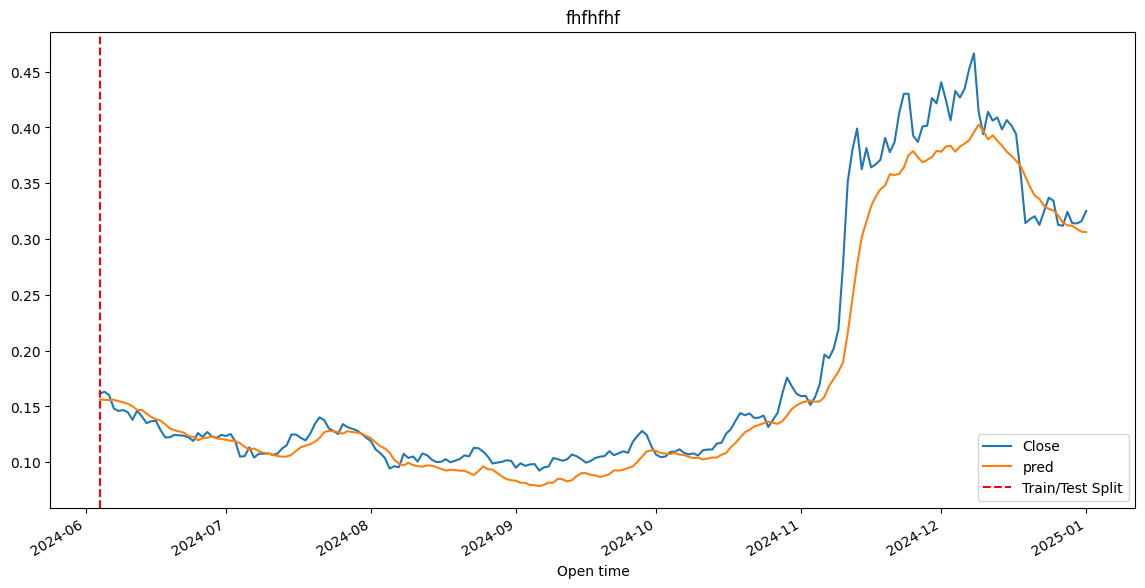

In [9]:
df["pred"] = np.nan
df.loc[df.index[-len(y_pred_inv):], "pred"] = y_pred_inv
df[["Close", "pred"]].iloc[-len(y_pred_inv):].plot(figsize=(14, 7), title="fhfhfhf")

plt.axvline(x=df.index[-len(y_pred_inv)], color='red', linestyle='--', label='Train/Test Split')
plt.legend()

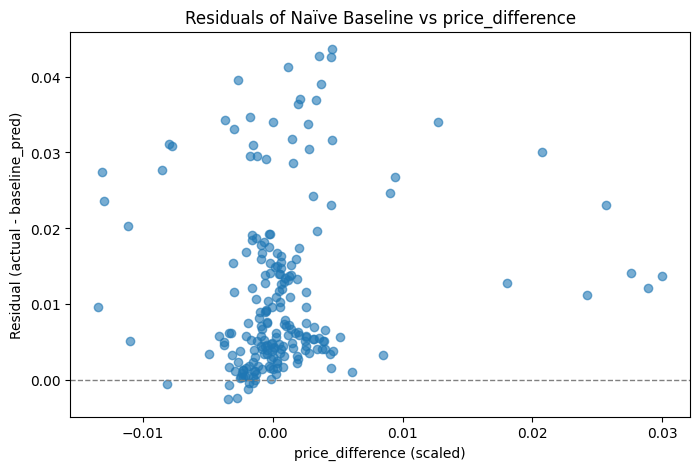

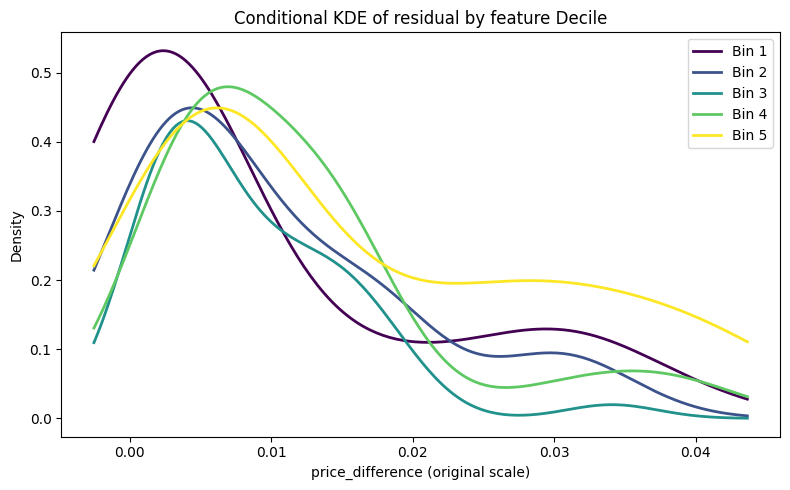

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats



# 3) Compute residuals relative to baseline
# residuals_baseline = preds - baseline_preds
residuals_baseline = y_val_inv - y_pred_inv

# 4) Extract the same feature (e.g. 'RSI') for X-axis
feature_to_plot = 'price_difference'  # or 'RSI', etc.

X_feat = y_val_inv - pd.Series(y_val_inv).shift(1)


# 5) Plot residuals of the benchmark vs. feature
plt.figure(figsize=(8,5))
plt.scatter(X_feat, residuals_baseline, alpha=0.6)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xlabel(f'{feature_to_plot} (scaled)')
plt.ylabel('Residual (actual - baseline_pred)')
plt.title(f'Residuals of Naïve Baseline vs {feature_to_plot}')
plt.show()


# fig, (ax_scatter, ax_hist) = plt.subplots(2, 1, figsize=(8, 10))

# # Scatter: baseline residuals vs feature
# ax_scatter.scatter(X_feat, residuals_baseline, alpha=0.6)
# ax_scatter.axhline(0, color='gray', linestyle='--', linewidth=1)
# ax_scatter.set_xlabel(f'{feature_to_plot} (scaled)')
# ax_scatter.set_ylabel('Residual (actual - baseline_pred)')
# ax_scatter.set_title(f'Residuals of Naïve Baseline vs {feature_to_plot}')

data = pd.DataFrame({'X': residuals_baseline, 'Y': X_feat})
data.dropna(inplace=True)


# bins = np.quantile(data['Y'], np.linspace(0, 1, 11))
# cond_vals = []
# for i in range(len(bins)-1):
#     mask = (data['Y'] >= bins[i]) & (data['Y'] < bins[i+1])
#     x_bin = data.loc[mask, 'X']
#     if len(x_bin) > 1:
#         x_std = (x_bin - x_bin.mean()) / x_bin.std(ddof=0)
#         cond_vals.append(x_std)
# cond_X = pd.concat(cond_vals, ignore_index=True)

# ax_hist.hist(cond_X, bins=30, density=True, alpha=0.7)
# ax_hist.set_xlabel(f'{feature_to_plot} (standardized within Y-bins)')
# ax_hist.set_ylabel('Density')
# ax_hist.set_title('Distribution of Detrended Conditional Feature')

# plt.tight_layout()
# plt.show()

bins = np.quantile(data['Y'], np.linspace(0, 1, 11))
bins = np.quantile(data['Y'], np.linspace(0, 1, 6))

# Prepare a grid for plotting
x_min, x_max = data['X'].min(), data['X'].max()
x_grid = np.linspace(x_min, x_max, 200)

# Choose a colormap and number of bins
cmap = plt.get_cmap("viridis")
n_bins = len(bins) - 1
z_grid = np.linspace(-3, 3, 200)   # covers ±3σ

plt.figure(figsize=(8,5))
for i in range(n_bins):
    mask = (data['Y'] >= bins[i]) & (data['Y'] < bins[i+1])
    x_bin = data.loc[mask, 'X']
    if len(x_bin) > 1:
        # Standardize within bin
        mean_i = x_bin.mean()
        std_i  = x_bin.std(ddof=0)
        x_std = (x_bin - mean_i) / std_i
        
        # Fit KDE on standardized data
        kde = stats.gaussian_kde(x_std)
        
        # Evaluate KDE on grid (standardize grid same as x_bin)
        x_std_grid = (x_grid - mean_i) / std_i
        y_kde = kde(x_std_grid)

        
        z = (x_bin - x_bin.mean()) / x_bin.std(ddof=0)
        # fit KDE
        kde = stats.gaussian_kde(z)
        # evaluate on the z-grid
        y_kde = kde(z_grid)
        
        # Compute color and line width as gradient
        frac = i / (n_bins - 1)
        color = cmap(frac)
        # linewidth = 0.5 + 2.5 * frac
        linewidth = 2

        if len(x_bin) < 30:
            alpha = 0.5
            linewidth = 0.5
        else:
            alpha = 1
        
        plt.plot(
            x_grid, kde(x_std_grid),
            color=color,
            linewidth=linewidth,
            label=f'Bin {i+1}',
            alpha=alpha
        )
        plt.xlabel(f'{feature_to_plot} (original scale)')
        plt.ylabel('Density')

        # plt.plot(
        #     z_grid, kde(z_grid),
        #     color=cmap(frac),
        #     linewidth=0.5 + 2.5*frac,
        #     label=f'Bin {i+1}'
        # )
        # plt.xlabel(f'z-score of {feature_to_plot}')
        # plt.ylabel('Density')

plt.title('Conditional KDE of residual by feature Decile')
plt.legend()
# Optional: only show legend if desired
# plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [11]:
# Save the trained model
best_model.save(SAVE_MODEL)

# Save the scaler
joblib.dump(best_scaler, SAVE_SCALER)

# Save the dataframe
best_df_all.to_csv(SAVE_DF)

# Save validation predictions with date index
val_predictions = pd.DataFrame({
    "Date": df.index[-len(best_y_val):],
    "Actual": y_val_inv,
    "Predicted": y_pred_inv
})
val_predictions.set_index("Date", inplace=True)
val_predictions.to_csv(SAVE_PREDICTIONS)